In [1]:
import os
import gc
from math import ceil
from typing import Tuple, Union

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import wandb
from tqdm import tqdm
from datasets import load_dataset

from upscaler import Upscaler
from colorizer import Colorizer
from dataloader import NoisyImageNetDataset

/scratch/swayam/miniconda3/envs/mast3r/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Restorer(nn.Module):
    """Model that colorizes and upscales the images."""
    def __init__(
            self,
            kernel_size: Union[int, Tuple[int, int]] = 5,
            sigma_color: float = 0.1,
            sigma_space: Union[float, Tuple[float, float]] = 1.5,
        ) -> None:
        super().__init__()

        self.colorizer = Colorizer(kernel_size, sigma_color, sigma_space)
        self.upscaler = Upscaler()

    def forward(self, x, gt):
        """Forward pass of the model.

        Args:
            x: The input tensor of shape (BATCH_SIZE, 1, 270, 512).

        Returns:
            The output tensor of shape (BATCH_SIZE, 3, 2160, 4096).
        """
        x = self.colorizer(x, gt)  # (BATCH_SIZE, 3, 270, 512)
        # x = self.upscaler(x)   # (BATCH_SIZE, 3, 2160, 4096)

        return x

In [3]:
LR                 = 1e-4
DEVICE             = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WANDB_LOG          = True
CACHE_DIR          = "/scratch/swayam/other_stuff/DIP/ImageNet-1k/"
NUM_EPOCHS         = 1
BATCH_SIZE         = 8
WEIGHT_DECAY       = 1e-3
VAL_FREQUENCY      = 10000
MAX_VAL_BATCHES    = 1250
SCHEDULER_FACTOR   = 0.5
SCHEDULER_PATIENCE = 2
CHECKPOINT_DIR     = "/scratch/swayam/other_stuff/DIP/checkpoints/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [4]:
val_dataset = load_dataset(
    'imagenet-1k', split='validation', streaming=True,
    cache_dir=CACHE_DIR, trust_remote_code=True
)
noisy_val_dataset = NoisyImageNetDataset(val_dataset)

In [5]:
sample = next(iter(noisy_val_dataset))

denoised_gray = sample['denoised_gray'].unsqueeze(0).to(DEVICE)
# denoised_gray = sample['denoised_gray'].to(DEVICE)
original_rgb  = sample['original_rgb'].unsqueeze(0).to(DEVICE)

In [6]:
model = Restorer().to(DEVICE)
checkpoint_name = "colorizer_bug_0.0001_0.01_250_50_epoch_1_batch_3250.pth"
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, checkpoint_name))['model_state_dict'])
model.eval()

with torch.no_grad():
    denoised_rgb = model(denoised_gray, original_rgb)

/tmp/ipykernel_3115533/4171249330.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, checkpoint_name))['model_

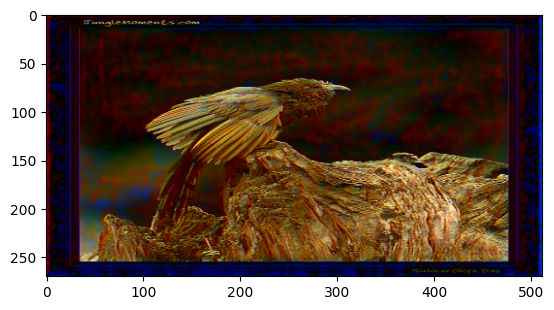

In [7]:
import cv2

# do min-max scaling over denoised_rgb
denoised_rgb_temp = denoised_rgb.clone().clamp(0, 1)
# denoised_rgb_temp -= denoised_rgb_temp.min()
# denoised_rgb_temp /= denoised_rgb_temp.max()
# denoised_rgb_temp *= 255
import matplotlib.pyplot as plt
plt.imshow(denoised_rgb_temp.squeeze().permute(1, 2, 0).cpu().numpy())

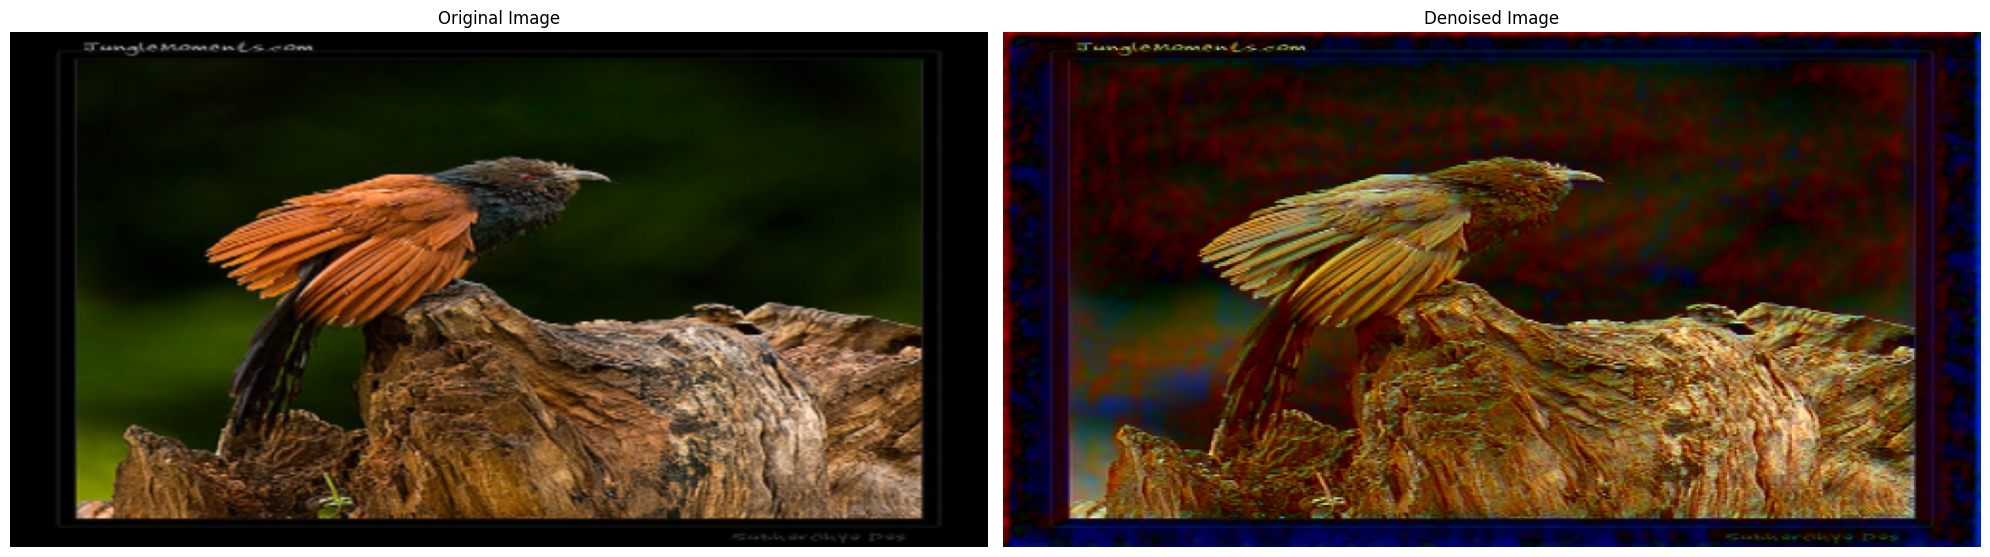

In [8]:
import matplotlib.pyplot as plt

upscaled_original = F.interpolate(original_rgb, scale_factor=8, mode='bilinear', align_corners=False)

_, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(upscaled_original[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(denoised_rgb[0].permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Denoised Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()